# Machine Learning
#### Going Down the EECS Stack DeCal Spring 2018

In this notebook, we'll explore various machine learning techniques and look at a few datasets.

First we'll explore some ideas behind machine learning using housing data from San Francisco and New York. </br>
Data courtesy of [r2d3](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
<img src="https://grapecollective.com/media/article/image/cache/720x337-center/c/o/comparison.jpg">
Each data point corresponds to a house with the following fields:
- year_built (int, e.g. 1990)
- price_per_sqft (int, dollars)
- bath (float)
- beds (float)
- elevation (int, ft)
- price (int, dollars)
- in_sf (int, 1 if in sf, 0 otherwise)

In the first part of this notebook we'll try to classify houses and predict whether a house is from NYC or SF. In the second part we'll try to regress and predict the prices of the houses.

<br />
Mathy Notation for later parts:
- $n$ denotes the number of data points (houses) 
- $d$ denotes the number of features 
- $X$ is an $n \times d$ matrix, where each row corresponds to a house. $X_i$ means the $i$th row, or the $i$th feature vector.
- $y$ is a length $n$ vector, where each index corresponds to a label. $y_i$ means the label for the $i$th house. For part 1 the labels are either $1$ or $0$ for SF and NYC respectively. For part 2 the labels are real numbers denoting housing price.

In [1]:
# imports
import numpy as np
%matplotlib notebook
from sklearn.metrics import mean_absolute_error, r2_score
from IPython.display import clear_output
from time import sleep
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from util import extract_cols, visualize_linear_regression, visualize_perceptron, load_data
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'util'

In [ ]:
# load housing data
all_data, features_c, labels_c, features_r, labels_r = load_data()

## Part 1: Classification: NYC vs SF
In this section, our goal is to learn a model that predicts whether a given house is from SF or from NYC. Our label is "is_sf", which is 1 if the house belongs to SF, 0 if NYC.

### Part 1.1 Manual Classification
1. Use the cells below to explore statistics about the housing data. Note the mean and range of certain features. Which feature helps differentiating nyc and sf houses the most?
2. Use your knowledge about the data to fill in the function "is_in_sf," which takes in a feature dictionary and returns 1 if you think this house belongs in SF, 0 if it belongs to NY
3. Test how good your result is. Try to improve your score as much as possible!

In [ ]:
def plot_housing_histogram(feature_name):
    '''
    statistic is either 'mean', 'std', 'min', 'max'
    feel free to modify this function to explore other properties about the housing data.
    '''
    if feature_name not in features_c[0]:
        raise ValueError("Invalid feature_name!")
        
    sf = []
    nyc = []
    for data in all_data:
        if data['in_sf']:
            sf.append(data[feature_name])
        else:
            nyc.append(data[feature_name])
    
    plt.figure()
    bins = np.histogram(np.hstack((sf, nyc)), bins=50)[1]
    plt.hist(sf, bins, alpha=0.5, facecolor='red', label='SF')
    plt.hist(nyc, bins, alpha=0.5, facecolor='blue', label='NYC')
    plt.xlabel(feature_name)
    plt.ylabel('number of houses')
    plt.title('Histogram of SF and NYC Houses by {}'.format(feature_name))
    plt.legend()
    
    print 'SF | mean: {}, std: {}, min: {}, max: {}'.format(np.mean(sf), np.std(sf), min(sf), max(sf))
    print 'NYC | mean: {}, std: {}, min: {}, max: {}'.format(np.mean(nyc), np.std(nyc), min(nyc), max(nyc))    

In [ ]:
# 1) explore the data
# available features are price, year_built, bath, beds, elevation, price_per_sqft
plot_housing_histogram('price')

In [ ]:
# 2) Implement is_in_sf
def is_in_sf(feature):
    '''
    feature is a dictionary with the following keys: 
    - 'year_built'
    - 'price_per_sqft'
    - 'bath'
    - 'beds'
    - 'elevation'
    - 'price'
    
    return 1 if house is predicted to be in SF, 0 if NYC    
    '''
    ### Your Code Below ###
    return 0

In [ ]:
# 3) Test your performance!
num_correct = 0
sf_but_pred_ny = 0
total_num = len(features_c)
for i, feature in enumerate(features_c):
    prediction_in_sf = is_in_sf(feature)
    if prediction_in_sf == labels_c[i]:
        num_correct += 1
    else:
        if labels_c[i] and not prediction_in_sf:
            sf_but_pred_ny += 1
print "Got {:.2f}% correct!".format(num_correct/1./total_num*100)
print "Out of incorrect predictions, {:.2f}% were SF houses predicted to be in NYC".format(
                                                                                sf_but_pred_ny/1./(total_num - num_correct)*100)

### Part 1.2 The Perceptron Algorithm

In this section we will implement the perceptron algorithm, which will learn a linear decision boundary function $f(x)$ of the form:
$$
f(X_i) = \left\{
        \begin{array}{ll}
            1 & \quad w^\top X_i + b > 0 \\
            0 & \quad else
        \end{array}
    \right.
$$
You can think of this function as drawing a line in the feature space. If a data point is above this line, we'll say it's from SF. If a data point is below this line, we'll say it's from NYC. In the 1D case where there is only 1 feature used, $w$ would be the slope of the line, and $b$ the y-intercept.

<br />

Note that $f$ is *parameterized* by $w$ and $b$. So our goal is to find the $w$ and $b$ that best minimizes a *loss* function:
$$
L(X, y) = \frac{1}{N} \sum_{i=1}^{N} (f_{w, b}(X_i) - y_i)^2
$$

The learning update equations for the perceptron algorithm are:
$$
error = (w^\top x + b) - y
$$
$$
w = w + \alpha * error * x
$$
$$
b = b + \alpha * error
$$

<br />
The perceptron algorithm has 2 *hyperparameters*: the learning rate ($\alpha$) and the number of epochs to be trained on. In addition, we can also select a smaller set of features instead of using all of them to learn on (sometimes this performs better). Complete the steps below:
1. Implement the perceptron algorithm
2. Experiment w/ learning rate and epochs. How do these affect the train and test performance? Why?
3. Experiment w/ feature selection. Which features seem to work the best? Why?
4. Tweak the above settings to get the best test performance. 
5. If you used 2 or 3 features, you can run the visualization code to visualize the decision boundary.

In [ ]:
# helper functions
def f(w, b, x):
    if w.dot(x) + b > 0:
        return 1
    else:
        return 0

def classification_accuracy(X, y, w, b):
    y_pred = [f(w, b, x) for x in X]
    return (1 - mean_absolute_error(y_pred, y))*100

def regression_mae(X, y, w, b):
    y_pred = X.dot(w) + b
    return mean_absolute_error(y_pred, y)

In [ ]:
# 1) Read this implementation. Try matching it with the pseudocode
def perceptron_learn_w_b(X_tr, y_tr, X_t, y_t, epochs, learning_rate, features_to_use=None, vis=False):
    '''
    Run the perceptron algorithm for epochs iterations
    Return w, b
    '''
    # dimensions
    N = X_tr.shape[0] # number of data points we have
    d = X_tr.shape[1] # dimension of a feature vector
    
    # initialize weights
    w = np.zeros(d) # a vector of 0's of size d
    b = 0 # bias starts at 0
    
    if vis and d in (2, 3):
        fig = plt.figure()
    
    # perceptron learning algorithm
    for t in range(epochs):
        for i in range(N):            
            x = X_tr[i]
            pred_y = f(w, b, x)
            error = y_tr[i] - pred_y
            
            ### begin student code ###
            
            ### end student code ###
        
        if vis and d in (2, 3):
            fig.clf()
            visualize_perceptron(features_to_use, X_tr, y_tr, w, b, fig)
            fig.canvas.draw()
            sleep(1)
        
        # reporting accuracy
        train_accuracy = classification_accuracy(X_tr, y_tr, w, b)
        test_accuracy = classification_accuracy(X_t, y_t, w, b)
        #clear_output(wait=True)
        print 'epoch={}/{} | train={:.2f}% | test={:.2f}%'.format(t+1, epochs, train_accuracy, test_accuracy)
                
    return w, b

In [ ]:
# 2) Choose hyperparameters
epochs = 100
learning_rate = 0.1

In [ ]:
# 3) Choose which features to use
# available features are 'bath', 'beds', 'year_built', 'price_per_sqft', 'elevation', 'price'
# experiment with a subset of these to find what works best
features_to_use_c = ['bath', 'beds', 'year_built', 'price_per_sqft', 'elevation'] # please use 2 or 3 features here

In [ ]:
# 4) Run this cell to train perceptron!
index_train_split = int(0.8 * len(features_c))
features_c_small = extract_cols(features_c, features_to_use_c)
features_c_train_array, features_c_test_array = features_c_small[:index_train_split], features_c_small[index_train_split:]
labels_c_train_array, labels_c_test_array = np.array(labels_c[:index_train_split]), np.array(labels_c[index_train_split:])

w_c, b_c = perceptron_learn_w_b(features_c_train_array, labels_c_train_array, features_c_test_array, labels_c_test_array, 
                            10, learning_rate, features_to_use=features_to_use_c, vis=True)
print 'w is ', w_c, 'b is ', b_c

In [ ]:
# 5) visualize data and learned decision boundary
visualize_perceptron(features_to_use_c, features_c_train_array, labels_c_train_array, w_c, b_c)

## Part 2 Regression on Housing Price

In this section, our goal is to learn a model that predicts house prices. Our label is now "price" instead of "in_sf." "in_sf" is now included as a feature.

Regression, unlike classification, predicts a continuous range of values instead of discrete classes.

### Part 2.1 Linear Regression for Expected House Price

In linear regression, we use a linear function to map from input features to output labels. Similar to the perceptron algorithm above, this model has the form:
$$
y_i = w^\top X_i + b
$$
The new $f$ for regression which outputs the predicted $y$ values will be:
$$
f(X_i) = w^\top X_i + b
$$
Our loss function will be the same as above:
$$
L(X, y) = \frac{1}{N} \sum_{i=1}^{N} (f_{w, b}(X_i) - y_i)^2
$$

We have a closed form solution for this problem. If $X$ is a matrix of features and $y$ the list of labels, then we can write:
$$
w = X^\star y
$$
$$
b = \frac{1}{N} \sum_{i=1}^{N} y_i
$$

Where $X^\star$ is the pseudoinverse of $X$.

To evaluate how good our predictor is, we compute two metrics - mean absolute error and the coefficient of determination (r2 score). Mean absolute error is the average absolute difference of our predicted house price and the true house price. This number however can be difficult to interpret, so we introduce another metric called the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), or r2 score. R2 scores roughly compute how good a set of predictions are given ground truth data. A higher r2 score means better predictions, and 100% accuracy correspond to an r2 score of 1. 

Complete the steps below:
1. Implement Linear Regression using $b$ as the mean of $y$ and $w$ the pseudoinverse of $X$
2. Experiment with which features to use to get the best performance
3. Run Linear Regression. Observe results.
4. Visualize the linear regression line for when using only 1 feature or 2 features.
5. Are the results good or bad? Why?

In [ ]:
# 1) Implement Linear Regression
def linear_regression(X_tr, y_tr, X_t, y_t):
    '''
    return weight vector w and bias b
    hints:
    - np.mean(x) returns the mean of x
    - np.linalg.pinv returns the pseudoinverse of x
    - a.dot(b) returns the dot product of a and b
    '''
    ### begin student code ###
    
    ### End student code ##
    
    train_mae = regression_mae(X_tr, y_tr, w, b)
    test_mae = regression_mae(X_t, y_t, w, b)
    
    print "Train MAE {} | Test MAE {}".format(train_mae, test_mae)   
    
    return w, b

In [ ]:
# 2) Choose which features to use
# available features are 'bath', 'beds', 'year_built', 'price_per_sqft', 'elevation', 'in_sf'
# experiment with a subset of these to find what works best
features_to_use_r = ['bath', 'beds', 'year_built', 'price_per_sqft', 'elevation', 'in_sf']

In [ ]:
# 3) Run this cell to run linear regression
index_train_split = int(0.8 * len(features_r))
features_r_small = extract_cols(features_r, features_to_use_r)
features_r_train_array, features_r_test_array = features_r_small[:index_train_split], features_r_small[index_train_split:]
labels_r_train_array, labels_r_test_array = np.array(labels_r[:index_train_split]), np.array(labels_r[index_train_split:])

w_r, b_r = linear_regression(features_r_train_array, labels_r_train_array, features_r_test_array, labels_r_test_array)

# Computing linear regressor's r2 score using the linear regressor above
pred_tr_linear = features_r_train_array.dot(w_r) + b_r
pred_t_linear = features_r_test_array.dot(w_r) + b_r
pred_tr_linear_r2 = r2_score(pred_tr_linear, labels_r_train_array)
pred_t_linear_r2 = r2_score(pred_t_linear, labels_r_test_array)
print "Linear Regressor | Train r2 {:.2f}. Test r2 {:.2f}".format(pred_tr_linear_r2, pred_t_linear_r2)

print 'w is ', w_r, 'b is ', b_r

In [ ]:
# 5) Visualize linear predictor for 1 or 2 features
visualize_linear_regression(features_to_use_r, features_r_train_array, labels_r_train_array, w_r, b_r)

### Part 2.2 Regression with Decision Tree

The main drawback of linear regression is that it is a model with low expressiveness (or representational power) - it can't fit to complex patterns in data. Another popular method in supervised learning is called Decision Tree. Below we demonstrate fitting this data using decision trees and show the improvements in prediction.

<br />
Complete the following steps:
1. Change the depth hyperparameter and run Decision Tree Regressor
2. Compute r2 scores for decision tree
3. Slowly increase the depth from:
    - What depth achieves the best train performance?
    - What depth achieves the best test performance?
    - At what depth does the test performance begin to decrease? Why?
4. Export and visualize decision tree using dot. Open .dot file, and copy the contents to this [site](http://dreampuf.github.io/GraphvizOnline/) to generate the visualization. Compare results with your neighbors. 
    - Which features are being split on? 
    - Which feature is the most important one?
    - Are these feature splits expected/surprising?

In [ ]:
# 1) Train a Decision Tree Regressor
depth = 1 # Experiment with this value to see the balance between train and test performance
decision_tree = DecisionTreeRegressor(max_depth=depth)
decision_tree.fit(features_r_train_array, labels_r_train_array)

In [ ]:
# 2) Compute decision tree regressor's MAE and r2 score
pred_tr_decisiontree = decision_tree.predict(features_r_train_array)
pred_t_decisiontree = decision_tree.predict(features_r_test_array)
pred_tr_decisiontree_r2 = r2_score(pred_tr_decisiontree, labels_r_train_array)
pred_t_decisiontree_r2 = r2_score(pred_t_decisiontree, labels_r_test_array)
print "Decision Tree Regressor | Train MAE {:.2f}. Test MAE {:.2f}".format(
                            mean_absolute_error(pred_tr_decisiontree, labels_r_train_array),
                            mean_absolute_error(pred_t_decisiontree, labels_r_test_array))
print "Decision Tree Regressor | Train r2 {:.2f}. Test r2 {:.2f}".format(pred_tr_decisiontree_r2, pred_t_decisiontree_r2)

In [ ]:
# 3) export decision tree
export_graphviz(decision_tree, out_file='decision_tree_regressor.dot', feature_names=features_to_use_r)

# Neural Nets and MNIST
We will now explore neural networks using the MNIST dataset.

The MNIST dataset is a large collection of handwritten digits commonly used to train and evaluate image processing algorithms. You can see the performance of difference machine learning algorithms here: http://yann.lecun.com/exdb/mnist/ Note that some of the best algorithms can achieve an error rate of less than a percent. Many of those algorithms make use of neural networks, in particular convolutional neural nets (CNNs) which are especially well-suited to image classification.

Today our goal is to build a simple neural network to classify these images.
<img src="files/mnist.png">

# What is a Neural Network?

A neural network is a machine learning algorithm well-suited for handling large amounts of data and using it to make predictions or classify objects. Commercial applications of these technologies generally focus on solving complex signal processing or pattern recognition problems. Examples of significant commercial applications since 2000 include handwriting recognition for check processing, speech-to-text transcription, oil-exploration data analysis, weather prediction and facial recognition.

A neural network usually involves a large number of neurons operating in parallel and arranged in tiers. The first tier receives the raw input information - analogous to optic nerves in human visual processing. Each successive tier receives the output from the tier preceding it, rather than from the raw input. The last tier produces the output of the system. Each processing node has its own small sphere of knowledge, including what it has seen and any rules it was originally programmed with or developed for itself. In defining the rules and making determinations - that is, each node decides what to send on to the next tier based on its own inputs from the previous tier.

Essentially a neural network consists of layers of small units, each with their own weights and responsible for a small amount of computation. Input is fed through these layers and the units work together to produce their decision.

(Credit: http://searchnetworking.techtarget.com/definition/neural-network)

<img src="files/neural_net.jpeg">

# The Data - Training an Algorithm
Good data is the key to a good algorithm. To train a classifier, we need a dataset which tells us the correct output for a given input. Essentially, we need to provide it with examples of what we want it to do (this is called supervised learning). Fortunately for us, scikit-learn allows us to import datasets so we do not have to label thousands of images ourselves.

When evaluating a machine learning algorithm it is important to split up the data into train and test sets. This will help us accurately evaluate the effectiveness of our predictions and help prevent overfitting. We use the training set to train our model and then use the test set to see how accurate our model's predictions are. If we trained on the entire dataset, it would be difficult to see how well our algorithm handles new input since we would be giving it data that it has seen before (and thus within our algorithm we have already kind of encoded the answer). The whole point is to make predictions about new data (we already know the answers to the given data) and it would be bad if our algorithm couldn't sufficiently generalize.

In [2]:
import numpy
import sklearn
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

Let's load the data and split it into train and test sets. Take a look at what the images look like and their respective labels (X and Y). Note that the images are stored as an unrolled 1-d vector. We have reconstructed the images by reshaping them to display what they originally looked like.

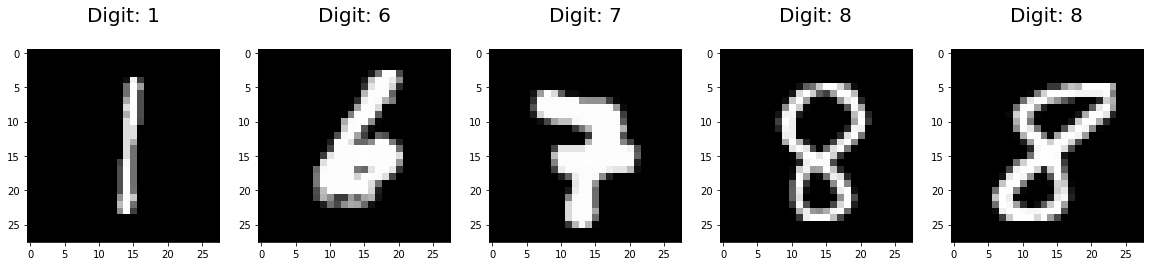

In [3]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt


# do some data preprocessing (nothing currently done)
processed_data = mnist.data
processed_target = mnist.target

X_train, X_test, Y_train, Y_test = train_test_split(processed_data, processed_target, test_size=.25)

plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(X_train[0:5], Y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Digit: %i\n' % label, fontsize = 20)

# Logistic Classifier

<img src="files/logistic.png">

Before we make a full neural net, let us look at something a bit simpler - logistic regression. You may have seen a logistic curve in calculus, and we can use it to classify binary data. Logistic regression will allow us to determine the probability of an input being a 0 or a 1. Observe in the graph above that the items towards the left of the curve are more likely to be 0 and the items towards the right of the curve are more likely to be a 1. So if we are given an input value X with an unknown class Y, we can predict its class based on where it lies on the curve.

We can use a logistic classifier on its own to predict which digit an image is. We will do this first - imagine that we create one logistic curve for each digit, and for a given input return the digit which has the highest probability.

Training a logistic classifier is quite easy with scikit-learn. We will use the L-BFGS algorithm (limited memory Broyden–Fletcher–Goldfarb–Shanno algorithm) as our logistic solver. Note that it might take a bit of time to train. You can read more about the algorithm here: http://aria42.com/blog/2014/12/understanding-lbfgs

In [4]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(solver = 'lbfgs', verbose = 10)
logisticRegr.fit(X_train, Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   25.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   37.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   43.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   49.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   54.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   59.7s

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=10, warm_start=False)

Let's see how well our logistic classifier performs. Below you can see a given image, our prediction, and the actual digit. You can play around with the start variable to look at different segments of the data.

In [ ]:
start = 0 # enter a number from 0 to 17495

predictions = logisticRegr.predict(X_test[start:start+5])

plt.figure(figsize=(20,4))
for index, (image, predicted, actual) in enumerate(zip(X_test[start:start+5], predictions, Y_test[start:start+5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Predicted: %i | Actual: %i \n' %(predicted, actual), fontsize = 12)

Now let's look at how it performs on the dataset as a whole. We compare the predicted values with the actual values. You should get an accuracy of around 90%. Decent, but still quite a bit away from today's state-of-the-art algorithms. Let's see if our neural net can perform better. While neural networks can utilize logistic curves / sigmoids, today there are other more commonly used functions.

In [ ]:
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, Y_test)
print("Logistic classifier accuracy: " + str(score))

# Training a Neural Network
Before we create our neural network, let us first look at how neural networks make predictions and how they are trained.

## The Neurons
As mentioned earlier, neural networks are composed of layers of "neurons." Each neuron is responsible for its own little bit of computation. A neuron takes input from the layer before and combines them with some internal weights to generate a single output value. Before this value is passed onwards to the next layer, it is fed through a nonlinear activation function. Which activation function to use has varied over the years and also depends on the specific implementation, but RELUs (rectified linear units) are quite common today. Some other activation functions include the sigmoid, tanh, and maxout. These nonlinearities are part of what gives neural networks their power and distinguishes them from simple linear regression. With at least one intermediate hidden layer, a neural network is able to represent any continuous function. Hidden layers allow introduce more complexity into our predictor and allow us to classify even nonlinear data.

Observe that the inputs are simply combined as a linear combination with their respective weights (along with a bias term) to generate a value. This value is then passed through an activation function for the final output. The RELU activation function is f(x) = max(0, x). These outputs then form the input for the next neurons (depending on the type of layer, a neuron may use some or all of the outputs from the previous layer - we will be using fully connected layers so we will use all outputs from the previous layer). Calculating an output by passing an input through the layers of neurons (each responsible for their own computation) is called feed-forward computation.

A single neuron:
<img src="files/neuron.png">

Input is fed through the layers of neurons in a feedforward neural network.
<img src="files/neural_net.jpeg">

The RELU activation function f(x) = max(0, x): (note that it's basically just 2 line segments, but still quite powerful)
<img src="files/relu.jpeg">


## Loss and Backpropagation
Our neural net will output digit probabilities for each image (a vector containing 10 probabilities). Although it predicts the digit with the highest probability, we still want to consider all the probabilities when training our neural network. For instance our image was a 7, a prediction of 40% for a 7 and 60% for a 9 is better than a prediction of 100% for a 2. We want a metric that will contain that information - not just whether or not we were correct, but how close we were.

How do we measure how well our neural network performs? We must define a loss function. The data loss then takes the form of an average over the data losses for every individual example. So, the loss is: (1/N) * (L_1 + ... + L_N). A common loss and the one we'll be using for our neural network today is cross-entropy loss:
<img src="files/cross_entropy.png">
This loss is well-suited for prediction problems involving multiple classes (such as digits) and measures the distance between the predicted and actual distribution.

# Backpropagation
Once we have this loss, how can we use this error to improve our predictions? We want to minimize the loss (minimizing the error) and with neural networks we use a technique called backpropagation. Backpropagation is somewhat similar to gradient descent. In gradient descent, we look at the current slope of the graph and move down the slope towards the "bottom" of the hill. You can imagine that with enough iterations, we are able to find a "valley" in the graph which represents a minimum. In the graph below observe how the point moves downhill towards the blue valley.
<img src="files/gradient_descent.png">

You can imagine that the weights of our neurons are analogous to our coordinates on the graph, the loss as the height, and we look at the error to determine the slope.

With backpropagation, we are in essence doing this process for all the neurons in our network. However rather than simply using the final error / loss at the end for all neurons, we instead propagate that error backwards through the network, layer-by-layer. Thus each neuron has its own loss, based on the output it passed on to the layer after it. Backpropagation can thus be thought of as neurons communicating to each other (through the gradient signal) whether they want their outputs to increase or decrease (and how strongly), so as to minimize the total loss.

The math behind backpropagation relies on the chain rule for partial derivatives:
<img src="files/chain_rule.png">
Say f(x, y, z) is our final output function value and that f = (2x + 3y)z. In this case we sort of have 2 layers - the first is q = x + y and the second is f = qz. Let's say we want to see how x affects the final value f(x, y, z). We are given the final value f(x, y, z) along with inputs x, y, z. We can calculate the value of df/dq directly through derivation: df/dq = z. We also know the value of dq/dx is 2 (since q = 2x + 3y). Thus, we see that df/dx = 2z.

This is a simple example of backpropagation, but the actual backpropagation for a neural network is essentially the same, just on a larger scale.

If you haven't taken multivariable calculus and don't know partial derivatives, this might not make the most sense, but don't worry the library will handle the details of backpropagation for you.

# Putting it all Together
Let's create our neural net using scikit-learn. Using scikit-learn, we will feed each input in the training set through our neural network. For each input, we will perform backpropagation to improve our prediction and correct errors. Scikit-learn will handle the training for you - all you need to call is clf.fit(X, Y). Then we can check how accurate our neural network is.


In [ ]:
from sklearn.neural_network import MLPClassifier

# Change this!!!
# The hidden layers in our neural net - each number represents the number 
# of neurons in a layer (you can add more layers if you desire)
hidden_layers = (100, 50)

# defines our neural net
clf = MLPClassifier(activation = 'relu', learning_rate_init = 1e-3, alpha=1e-5, 
                    hidden_layer_sizes = hidden_layers, verbose = 10)

# trains the neural net
clf.fit(X_train, Y_train)

# evaluates accuracy of neural net
score = clf.score(X_test, Y_test)
print("~~~~~~~~~~~~~~~~~~~~~")
print("Classifier accuracy: " + str(score))

You can play around with the classifier parameters in the neural net definition above if you like - MLPClassifier(...), to see if you can improve the neural network. Play around with the number of neurons in each layer (you can also add more layers if you'd like), as the layers are not optimized. When you are done, rerun the code block above and see if you get an improvement. Also take a look at the learning rate and alpha parameter. The highest I could get was around a 96%.

For the hidden_layer_sizes parameter, the ith element is the number of neurons in the ith hidden layer. Remember that the hidden layers are the layers of neurons in between the input vector and the final output. Every iteration, the loss should be dropping. If it is not, consider decreasing "learning_rate_init" since the gradient might be bouncing back and forth around the valley (lower means that it moves a lesser amount).

<img src="files/gradient_bouncing.jpeg">

Note that low loss is correlated with predictive power, but you still need to watch out for overfitting (since the network could match the training data very well but not generalize well). Changing the alpha parameter (which controls regularization) will help prevent overfitting - higher alpha means less overfitting.

See how high your prediction can get. More neurons and layers may help, but is also slower to train and is more prone to overfitting.


The documentation is here: http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

If you want, you can take a look at some of the predictions made by the neural network.

In [ ]:
start = 0 # enter a number from 0 to 17495

predictions = clf.predict(X_test[start:start+5])

plt.figure(figsize=(20,4))
for index, (image, predicted, actual) in enumerate(zip(X_test[start:start+5], predictions, Y_test[start:start+5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Predicted: %i | Actual: %i \n' %(predicted, actual), fontsize = 12)

# Try some other algorithms
If you have the time, try other machine learning algorithms and see how well they perform. The documentation is here: http://scikit-learn.org/stable/modules/classes. Try playing around with the various parameters (you'll have to look in the documentation to see them).

For instance, here's one using a random forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier

# create an instance of the classifier
clf = RandomForestClassifier(verbose = 10)

# train the classifier (this may take some time)
clf.fit(X_train, Y_train)

# print accuracy
score = clf.score(X_test, Y_test)
print("~~~~~~~~~~~~~~~~~~~~~")
print("Classifier accuracy: " + str(score))

In [ ]:
start = 0 # enter a number from 0 to 17495

predictions = clf.predict(X_test[start:start+5])

plt.figure(figsize=(20,4))
for index, (image, predicted, actual) in enumerate(zip(X_test[start:start+5], predictions, Y_test[start:start+5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Predicted: %i | Actual: %i \n' %(predicted, actual), fontsize = 12)

# Thanks!
If you want to learn more about neural networks and machine learning, there are plenty of resources online. Much of this lab was inspired by Stanford's CS231n course here: http://cs231n.github.io/.

An example of an online course is this Coursera one on machine learning: https://www.coursera.org/learn/machine-learning